## Colin's active development sandbox

In [1]:
from enum import Enum
from pathlib import Path
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision as tv
import torchvision.transforms as transforms
import numpy as np
from tqdm.auto import tqdm
import os
import re
import cv2
from PIL import Image
import math
from concurrent.futures import ProcessPoolExecutor, as_completed
import matplotlib.pyplot as plt
import logging
import sys

sys.path.append(str(Path.cwd().parent.parent))
print(str(Path.cwd().parent.parent))
print("Current working directory: ", os.getcwd())

from DataProcessing.DataPreProcessing import DataPreProcessing, DataPaths
from DataProcessing.DataAugmentation import DataAugmentation, LegalTransformations, ImageEnhancement
LEGAL_TRANSFORMATIONS = list(LegalTransformations.__members__.keys())

c:\Users\colin\OneDrive\Desktop\UBC\Jersey-Number-Recognition
Current working directory:  c:\Users\colin\OneDrive\Desktop\UBC\Jersey-Number-Recognition\ModelDevelopment\experiments


### Tracklet iterator

In [2]:
def display_case_study(orig_tensor_batch, post_enhance_tensor, aug_dict, transformations):
    """
    Displays one image in a multi-row layout, where each row corresponds
    to a different augmentation from `transformations`.
    
    Left column: Original image
    Middle column: Augmented image (for that transformation)
    Right column: Post-enhanced image
    """
    # We assume `orig_tensor_batch_batch_batch` has shape (C, H, W) and `post_enhance_tensor` has shape (C, H, W)
    # while `aug_dict` is a dict mapping transformation keys to augmented tensors.
    num_rows = len(transformations)

    # Convert original image to [0..1] range for display
    orig_img = orig_tensor_batch.permute(1, 2, 0).numpy()
    orig_img = (orig_img - orig_img.min()) / (orig_img.max() - orig_img.min() + 1e-6)

    # Convert post-enhanced image
    post_img = post_enhance_tensor.permute(1, 2, 0).numpy()
    post_img = (post_img - post_img.min()) / (post_img.max() - post_img.min() + 1e-6)

    # Create figure
    fig, axs = plt.subplots(num_rows, 3, figsize=(6, num_rows * 2))
    if num_rows == 1:
        axs = [axs]

    for idx, trans in enumerate(transformations):
        # Retrieve the corresponding augmented image, or fallback to 'original'
        if trans in aug_dict:
            aug_tensor = aug_dict[trans]
        else:
            aug_tensor = aug_dict["original"]

        aug_img = aug_tensor.permute(1, 2, 0).numpy()
        aug_img = (aug_img - aug_img.min()) / (aug_img.max() - aug_img.min() + 1e-6)

        axs[idx][0].imshow(orig_img)
        axs[idx][0].set_title("Original")
        axs[idx][0].axis("off")

        axs[idx][1].imshow(aug_img)
        axs[idx][1].set_title(f"Augmented ({trans})")
        axs[idx][1].axis("off")

        axs[idx][2].imshow(post_img)
        axs[idx][2].set_title("Post-Enhanced")
        axs[idx][2].axis("off")

    plt.tight_layout()
    plt.suptitle("Case Study", fontsize=14, y=1.02)
    plt.show()


def display_single_augmentation(desired_transform, orig_tensor_batch_batch, post_enhance_batch, aug_dict_batch):
    """
    Displays each image in its own row, with three columns:
    Original, a single chosen augmented version, and the post-enhanced image.
    
    Args:
        orig_tensor_batch_batch: shape (N, C, H, W)
        post_enhance_batch: shape (N, C, H, W)
        aug_dict_batch: a list of length N, each an augmentation dictionary
                        for one image. (like augmented_data[track])
    """
    assert desired_transform in LEGAL_TRANSFORMATIONS, f"Invalid transformation: {desired_transform}"
    
    num_images = orig_tensor_batch_batch.shape[0]
    fig, axs = plt.subplots(num_images, 3, figsize=(6, num_images * 2))
    if num_images == 1:
        axs = [axs]

    for i in range(num_images):
        # Original
        orig_img = orig_tensor_batch_batch[i].permute(1, 2, 0).numpy()
        orig_img = (orig_img - orig_img.min()) / (orig_img.max() - orig_img.min() + 1e-6)

        axs[i][0].imshow(orig_img)
        axs[i][0].set_title("Original")
        axs[i][0].axis("off")

        # Choose a single augmented version (priority-based or random)
        aug_dict = aug_dict_batch[i]
        aug_tensor = aug_dict[desired_transform]

        aug_img = aug_tensor.permute(1, 2, 0).numpy()
        aug_img = (aug_img - aug_img.min()) / (aug_img.max() - aug_img.min() + 1e-6)

        axs[i][1].imshow(aug_img)
        axs[i][1].set_title(f"Augmented ({desired_transform})")
        axs[i][1].axis("off")

        # Post-enhanced
        post_img = post_enhance_batch[i].permute(1, 2, 0).numpy()
        post_img = (post_img - post_img.min()) / (post_img.max() - post_img.min() + 1e-6)
        axs[i][2].imshow(post_img)
        axs[i][2].set_title("Post-Enhanced")
        axs[i][2].axis("off")

    plt.tight_layout()
    plt.suptitle("Single Augmentation View", fontsize=14, y=1.09)
    plt.show()

In [3]:
# Toggle case-study mode: if True, we display one image with multiple augmentation variants.
CASE_STUDY = True
NUM_TRACKLETS = 1
NUM_IMGS_PER_TRACKLET = 1  # for case study, we assume one image per tracklet

data_pre = DataPreProcessing()
enhance = ImageEnhancement()

data_dict = data_pre.generate_features(DataPaths.TRAIN_DATA_DIR.value, DataPaths.PROCESSED_DATA_OUTPUT_DIR_TRAIN.value, num_tracks=NUM_TRACKLETS)
augmentor = DataAugmentation(data_dict, patch_mask_keep=0.8)

augmented_data = augmentor.augment_data(LEGAL_TRANSFORMATIONS)
selected_tracks = list(data_dict.keys())[:NUM_TRACKLETS]

[2025-03-02 20:08:28] - [INFO]: DataPreProcessing initialized. Universe of available data paths:
[2025-03-02 20:08:28] - [INFO]: ROOT_DATA_DIR: c:\Users\colin\OneDrive\Desktop\UBC\Jersey-Number-Recognition\data\SoccerNet\jersey-2023\extracted
[2025-03-02 20:08:28] - [INFO]: TEST_DATA_DIR: c:\Users\colin\OneDrive\Desktop\UBC\Jersey-Number-Recognition\data\SoccerNet\jersey-2023\extracted\test\images
[2025-03-02 20:08:28] - [INFO]: TRAIN_DATA_DIR: c:\Users\colin\OneDrive\Desktop\UBC\Jersey-Number-Recognition\data\SoccerNet\jersey-2023\extracted\train\images
[2025-03-02 20:08:28] - [INFO]: CHALLENGE_DATA_DIR: c:\Users\colin\OneDrive\Desktop\UBC\Jersey-Number-Recognition\data\SoccerNet\jersey-2023\extracted\challenge\images
[2025-03-02 20:08:28] - [INFO]: PRE_TRAINED_MODELS_DIR: c:\Users\colin\OneDrive\Desktop\UBC\Jersey-Number-Recognition\data\pre_trained_models
[2025-03-02 20:08:28] - [INFO]: REID_PRE_TRAINED: c:\Users\colin\OneDrive\Desktop\UBC\Jersey-Number-Recognition\data\pre_trained_

Loading tracklets:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
# Select the first tracklet
track = selected_tracks[0]

# Get the original tensor for this tracklet (shape: (N, C, H, W))
orig_tensor_batch = data_dict[track][:NUM_IMGS_PER_TRACKLET]

# Create the post-enhanced tensor by enhancing each image individually.
post_enhance_list = []
for i in range(orig_tensor_batch.shape[0]):
    enhanced_image = enhance.enhance_image(orig_tensor_batch[i])  # enhance_image expects a 3D tensor
    post_enhance_list.append(enhanced_image)
post_enhance_tensor_batch = torch.stack(post_enhance_list)  # shape: (N, C, H, W)

# Now, for case-study mode, we want to pass the augmentation dictionary 
# for that tracklet's first image as well. For example:
aug_dict_batch = augmented_data[track]
aug_dict_single = aug_dict_batch[0]

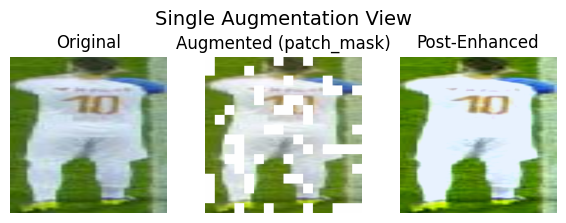

In [5]:
display_single_augmentation("patch_mask", orig_tensor_batch, post_enhance_tensor_batch, aug_dict_batch)

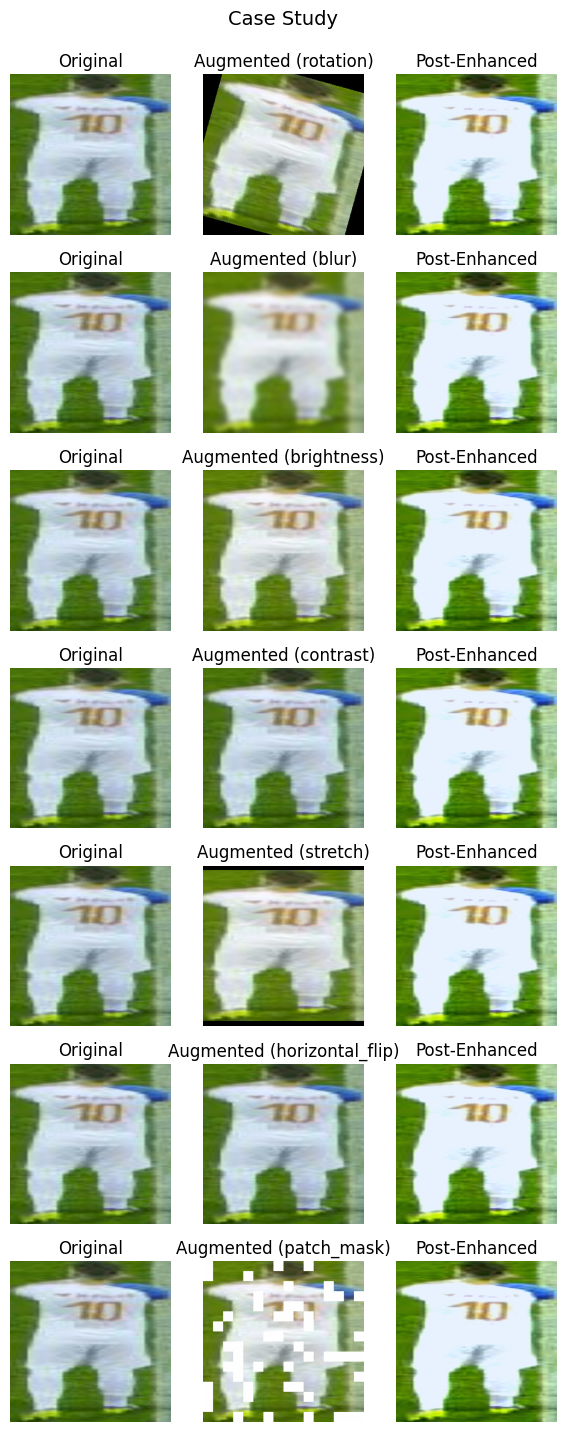

In [6]:
display_case_study(orig_tensor_batch[0], post_enhance_tensor_batch[0], aug_dict_single, LEGAL_TRANSFORMATIONS)

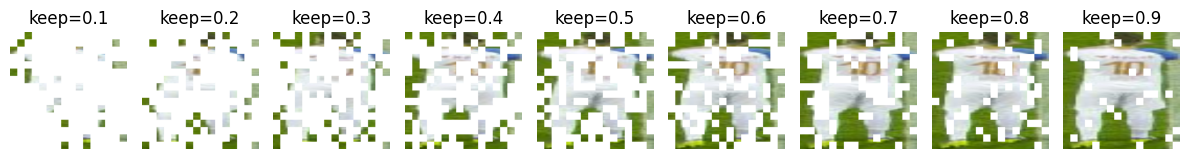

In [7]:
patch_threshs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Use one image from the batch (shape: (C, H, W))
image = orig_tensor_batch[0]
image_denorm = augmentor.denormalize(image)
pil_img = augmentor.to_pil(image_denorm)

# Use one row with as many columns as thresholds (capped at 6)
num_cols = min(len(patch_threshs), 6)
fig, axs = plt.subplots(1, len(patch_threshs), figsize=(12, 2))

for i, keep_fraction in enumerate(patch_threshs):
    masked_pil = augmentor.patch_masking(pil_img, keep_fraction, patch_size=16)
    masked_np = np.array(masked_pil, dtype=np.float32) / 255.0
    axs[i].imshow(masked_np)
    axs[i].set_title(f"keep={keep_fraction}")
    axs[i].axis("off")

plt.tight_layout()
plt.show()
